In [1]:
%pylab inline
from sklearn.metrics import *
import pandas as pd
import sklearn.preprocessing as sk
import os
import sys

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.stats as ss
import scanpy as sc
import seaborn as sns
import colorbm as cbm
import scipy.stats
import sklearn
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))

In [3]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [4]:
def plotROC(embAUClist,AUClist,N):
    fig, ax = plt.subplots(figsize=(5, 4))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for auc in AUClist:
        interp_tpr = np.interp(mean_fpr, auc[1], auc[2])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc[0])

        
    print(np.array(tprs).shape)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    sns.lineplot(x=mean_fpr,y=mean_tpr,ax=ax,label='Baseline',lw=3,color="#4DBBD5")
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for auc in embAUClist:
        interp_tpr = np.interp(mean_fpr, auc[1], auc[2])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc[0])
    sns.lineplot(x=[0, 1],y=[0, 1], linestyle = "--", label="AUC = 0.5",color='black',ax=ax)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    sns.lineplot(x=mean_fpr,y=mean_tpr,label='scFoundation',lw=3,color="#E64B35")

    ax.axis("square")
    ax.legend(loc="lower right");
    ax.set(
        xlim=[-0.02, 1.05],
        ylim=[-0.02, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{druglist[N]} \n Mean ROC curve on Bulk data",
    );
    return ax

# AUROC

In [5]:
druglist = ['Sorafenib','NVP-TAE684','PLX4720_451Lu','Etoposide']

In [6]:
Sorafenib_best = './results/Sorafenib/hdim512_zdim256_lr0.001_epoch20_lambda10.6_mbS8_mbT8_seed42.tsv'
NVPTAE684_best = './results/NVP-TAE684/hdim512_zdim512_lr0.001_epoch40_lambda10.8_mbS16_mbT16_seed42.tsv'
PLX4720_451Lu_best = './results/PLX4720_451Lu/hdim1024_zdim256_lr0.001_epoch100_lambda10.0_mbS16_mbT16_seed42.tsv'
Etoposide_best = './results/Etoposide/hdim1024_zdim512_lr0.001_epoch40_lambda10.6_mbS16_mbT16_seed42.tsv'
Emb_result = [Sorafenib_best,NVPTAE684_best,PLX4720_451Lu_best,Etoposide_best]

In [7]:
Emb_SCresult = [x.replace('.tsv','_predicted_y.tsv') for x in Emb_result]
Raw_SCresult = ['./results/Sorafenib/hdim512_zdim128_lr0.001_epoch20_lambda15.0_mbS8_mbT8_seed42_predicted_y.tsv',
             './results/NVP-TAE684/hdim1024_zdim128_lr0.001_epoch10_lambda12.0_mbS8_mbT8_seed42_predicted_y.tsv',
             './results/PLX4720_451Lu/hdim512_zdim256_lr0.001_epoch100_lambda11.0_mbS8_mbT8_seed42_predicted_y.tsv',
             './results/Etoposide/hdim512_zdim128_lr0.001_epoch10_lambda12.0_mbS8_mbT8_seed42_predicted_y.tsv']

In [8]:
ifsave=False

(120, 4)
(120, 4)
Emb AUC: 0.8388888888888889 Emb APR: 0.8490682642520877 Raw AUC: 0.5583333333333333 Raw APR: 0.6241483965630048
(5, 100)


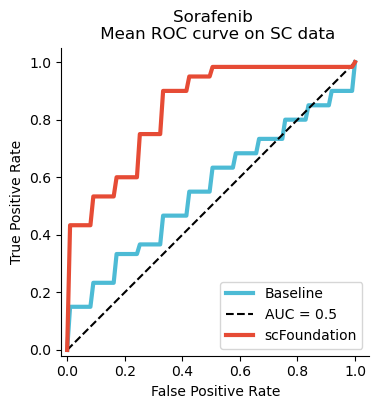

In [9]:
N=0
drugf = Emb_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)

embAUClist=[]
embAPRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    embAUClist.append([AUC_test,fpr,tpr,thresholds])
    embAPRlist.append(APR_test)    

drugf = Raw_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)


AUClist=[]
APRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    AUClist.append([AUC_test,fpr,tpr,thresholds])
    APRlist.append(APR_test)    
print('Emb AUC:',np.mean([x[0] for x in embAUClist]),'Emb APR:',np.mean(embAPRlist),'Raw AUC:', np.mean([x[0] for x in AUClist]),'Raw APR:',np.mean(APRlist))
ax = plotROC(embAUClist,AUClist,N)
ax.set(
    xlim=[-0.02, 1.05],
    ylim=[-0.02, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{druglist[N]} \n Mean ROC curve on SC data",
);
if ifsave:
    plt.savefig(f'SCROC_{druglist[N]}.pdf',bbox_inches='tight')

(120, 4)
(120, 4)
Emb AUC: 0.8388888888888889 Emb APR: 0.8562036071818679 Raw AUC: 0.6236111111111111 Raw APR: 0.6837555171561263
(5, 100)


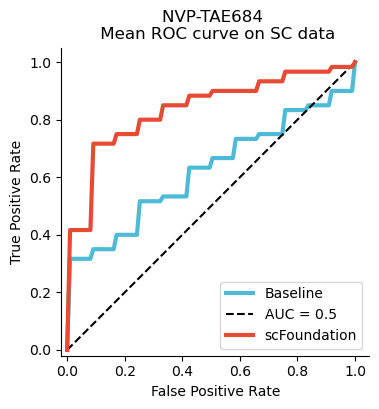

In [10]:
N=1
drugf = Emb_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)

embAUClist=[]
embAPRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    embAUClist.append([AUC_test,fpr,tpr,thresholds])
    embAPRlist.append(APR_test)    

drugf = Raw_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)


AUClist=[]
APRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    AUClist.append([AUC_test,fpr,tpr,thresholds])
    APRlist.append(APR_test)    
print('Emb AUC:',np.mean([x[0] for x in embAUClist]),'Emb APR:',np.mean(embAPRlist),'Raw AUC:', np.mean([x[0] for x in AUClist]),'Raw APR:',np.mean(APRlist))
ax = plotROC(embAUClist,AUClist,N)
ax.set(
    xlim=[-0.02, 1.05],
    ylim=[-0.02, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{druglist[N]} \n Mean ROC curve on SC data",
);
if ifsave:
    plt.savefig(f'SCROC_{druglist[N]}.pdf',bbox_inches='tight')

(155, 4)
(155, 4)
Emb AUC: 0.6585714285714286 Emb APR: 0.678941870394185 Raw AUC: 0.3761134453781513 Raw APR: 0.46911416689243557
(5, 100)


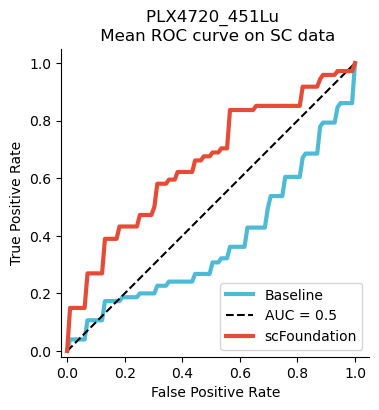

In [11]:
N=2
drugf = Emb_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)

embAUClist=[]
embAPRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    embAUClist.append([AUC_test,fpr,tpr,thresholds])
    embAPRlist.append(APR_test)    

drugf = Raw_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)


AUClist=[]
APRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    AUClist.append([AUC_test,fpr,tpr,thresholds])
    APRlist.append(APR_test)    
print('Emb AUC:',np.mean([x[0] for x in embAUClist]),'Emb APR:',np.mean(embAPRlist),'Raw AUC:', np.mean([x[0] for x in AUClist]),'Raw APR:',np.mean(APRlist))
ax = plotROC(embAUClist,AUClist,N)
ax.set(
    xlim=[-0.02, 1.05],
    ylim=[-0.02, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{druglist[N]} \n Mean ROC curve on SC data",
);
if ifsave:
    plt.savefig(f'SCROC_{druglist[N]}.pdf',bbox_inches='tight')

(1393, 4)
(1393, 4)
Emb AUC: 0.6793133214299365 Emb APR: 0.7233734803402377 Raw AUC: 0.6587100463577245 Raw APR: 0.6936947750959297
(5, 100)


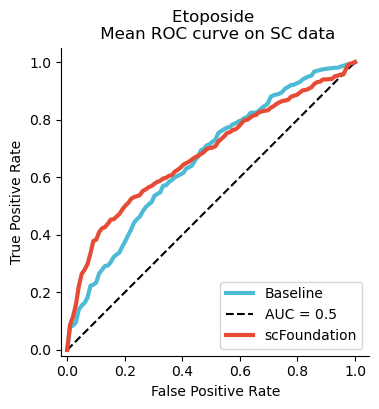

In [12]:
N=3
drugf = Emb_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)

embAUClist=[]
embAPRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    embAUClist.append([AUC_test,fpr,tpr,thresholds])
    embAPRlist.append(APR_test)    

drugf = Raw_SCresult[N]
drugr = pd.read_csv(drugf,sep='\t',header=None)
drugr.columns = ['fold','cellline','label','prob']
print(drugr.shape)


AUClist=[]
APRlist=[]
for spl in ['split1','split2','split3','split4','split5']:
    drugr_fold = drugr[drugr.fold==spl]
    AUC_test = roc_auc_score(drugr_fold.label,drugr_fold.prob)
    APR_test = average_precision_score(drugr_fold.label,drugr_fold.prob)
    fpr, tpr, thresholds = roc_curve(drugr_fold.label, drugr_fold.prob)
    AUClist.append([AUC_test,fpr,tpr,thresholds])
    APRlist.append(APR_test)    
print('Emb AUC:',np.mean([x[0] for x in embAUClist]),'Emb APR:',np.mean(embAPRlist),'Raw AUC:', np.mean([x[0] for x in AUClist]),'Raw APR:',np.mean(APRlist))
ax = plotROC(embAUClist,AUClist,N)
ax.set(
    xlim=[-0.02, 1.05],
    ylim=[-0.02, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{druglist[N]} \n Mean ROC curve on SC data",
);
if ifsave:
    plt.savefig(f'SCROC_{druglist[N]}.pdf',bbox_inches='tight')

# Episen rank

## NVP-TAE684

In [14]:
dname = 'NVP-TAE684'
tgtemb = np.load(f'data/split_norm/Target_expr_resp_19264.{dname}_50M-0.1B-res_tgthighres4_embedding.npy')
srcemb = np.load(f'data/split_norm/Source_exprs_resp_19264.{dname}_50M-0.1B-res_embedding.npy')

In [15]:
sourcebulk = pd.read_csv(f'./data/split_norm/Source_exprs_resp_z.{dname}.tsv', sep='\t', index_col=0)
targetexp = pd.read_csv(f'./data/split_norm/Target_expr_resp_z.{dname}.tsv', sep='\t', index_col=0)

In [16]:
sourcebulk.index = 'bulk_'+sourcebulk.index.astype(str)

In [18]:
cellmeta = pd.read_csv('./data/original_norm/Metadata.txt',sep='\t',index_col=0)
cellmeta = cellmeta.iloc[1:,:]

/tmp/ipykernel_28443/2249962561.py:1: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  cellmeta = pd.read_csv('./data/original_norm/Metadata.txt',sep='\t',index_col=0)


In [19]:
tgtmeta = cellmeta.loc[targetexp.index,:].copy()
tgtmeta['response'] = pd.DataFrame(targetexp.iloc[:,0])
tgtmeta['EpiSen_score'] = tgtmeta['EpiSen_score'].astype(float)

In [20]:
from scipy.stats import spearmanr
predresults = pd.read_csv(Emb_SCresult[1],sep='\t',header=None,index_col=1)
tgtmeta['pred'] = predresults.iloc[:,2]
tgtmeta['fold'] = predresults.iloc[:,0]

spr=[]
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.fold==spl].copy()
    spr.append(spearmanr(tmp['EpiSen_score'],tmp['pred'])[0])
print(spr)

[0.6295652173913043, 0.6695652173913044, 0.4513043478260869, 0.686086956521739, 0.3757338640681709]


In [21]:
rawpredresults = pd.read_csv(Raw_SCresult[1],sep='\t',header=None,index_col=1)
# rawpredresults = pd.read_csv('./results_norm/NVP-TAE684/bimodal/best_models/FX/seed42/test/mbS8_mbT8/hdim1024_zdim128_lr0.001_epoch10_lambda10.0_mbS8_mbT8_seed42_predicted_y.tsv',sep='\t',header=None,index_col=1)
tgtmeta['rawpred'] = rawpredresults.iloc[:,2]
tgtmeta['rawfold'] = rawpredresults.iloc[:,0]

rawspr=[]
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.rawfold==spl].copy()
    rawspr.append(spearmanr(tmp['EpiSen_score'],tmp['rawpred'])[0])
print(rawspr)

[0.7260869565217389, 0.6686956521739129, -0.2582608695652174, 0.21826086956521737, -0.18047402035681823]


In [22]:
print(np.mean(spr),np.mean(rawspr))

0.562451120639721 0.2348617176677667


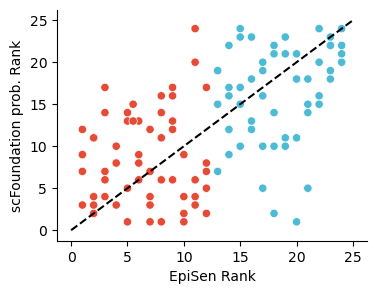

In [23]:
figsize(4,3)
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.fold==spl].copy()
    tmp['EpiSen_score_rank']=ss.rankdata(tmp['EpiSen_score'].tolist())
    tmp['pred_rank']=ss.rankdata(tmp['pred'].tolist())
    sns.scatterplot(data=tmp,x = 'EpiSen_score_rank',y='pred_rank',hue=tmp['response'])
    plt.legend([],[], frameon=False)
sns.lineplot(x=[25, 0],y=[25, 0], linestyle = "--", color='black')
plt.xlabel('EpiSen Rank')
plt.ylabel('scFoundation prob. Rank');
plt.legend([],[], frameon=False)
# plt.savefig(f'{dname}_ranksp.pdf',bbox_inches='tight')

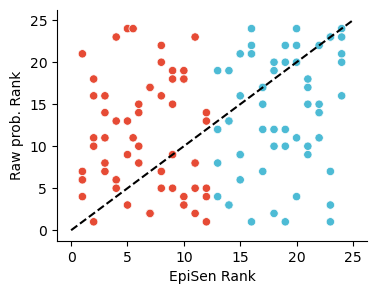

In [24]:
import scipy.stats as ss
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.rawfold==spl].copy()
    tmp['EpiSen_score_rank']=ss.rankdata(tmp['EpiSen_score'].tolist())
    tmp['rawpred_rank']=ss.rankdata(tmp['rawpred'].tolist())
    sns.scatterplot(data=tmp,x = 'EpiSen_score_rank',y='rawpred_rank',hue=tmp['response'])
    plt.legend([],[], frameon=False)
sns.lineplot(x=[25, 0],y=[25, 0], linestyle = "--", color='black')
plt.xlabel('EpiSen Rank')
plt.xticks(np.arange(0,30,5))
plt.yticks(np.arange(0,30,5))
plt.ylabel('Raw prob. Rank');
plt.legend([],[], frameon=False)
# plt.savefig(f'{dname}_rawranksp.pdf',bbox_inches='tight')

In [25]:
speardf = pd.DataFrame(spr,columns=['spear'])
speardf['mode']='scFoundation'
rawspeardf = pd.DataFrame(rawspr,columns=['spear'])
rawspeardf['mode']='Baseline'
allspeardf = pd.concat([speardf,rawspeardf],axis=0)

<AxesSubplot:xlabel='mode', ylabel='spear'>

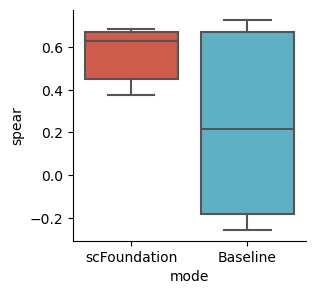

In [26]:
figsize(3,3)
sns.boxplot(data = allspeardf,x='mode',y='spear')

## Sorafenib

In [27]:
dname = 'Sorafenib'
tgtemb = np.load(f'data/split_norm/Target_expr_resp_19264.{dname}_50M-0.1B-res_tgthighres4_embedding.npy')
srcemb = np.load(f'data/split_norm/Source_exprs_resp_19264.{dname}_50M-0.1B-res_embedding.npy')

In [28]:
# sourcebulk = pd.read_csv('./data/split_norm/Source_exprs_resp_z.NVP-TAE684.tsv', sep='\t', index_col=0)
# targetexp = pd.read_csv('./data/split_norm/Target_expr_resp_z.NVP-TAE684.tsv', sep='\t', index_col=0)
sourcebulk = pd.read_csv(f'./data/split_norm/Source_exprs_resp_z.{dname}.tsv', sep='\t', index_col=0)
targetexp = pd.read_csv(f'./data/split_norm/Target_expr_resp_z.{dname}.tsv', sep='\t', index_col=0)

In [29]:
sourcebulk.index = 'bulk_'+sourcebulk.index.astype(str)

In [30]:
tgtmeta = cellmeta.loc[targetexp.index,:].copy()
tgtmeta['response'] = pd.DataFrame(targetexp.iloc[:,0])
tgtmeta['EpiSen_score'] = tgtmeta['EpiSen_score'].astype(float)

In [31]:
predresults = pd.read_csv(Emb_SCresult[0],sep='\t',header=None,index_col=1)
tgtmeta['pred'] = predresults.iloc[:,2]
tgtmeta['fold'] = predresults.iloc[:,0]

spr=[]
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.fold==spl].copy()
    spr.append(spearmanr(tmp['EpiSen_score'],tmp['pred'])[0])
print(spr)

[-0.6356521739130434, -0.5434782608695652, -0.7104347826086955, -0.5660869565217391, -0.2761469950038062]


In [32]:
rawpredresults = pd.read_csv(Raw_SCresult[0],sep='\t',header=None,index_col=1)
tgtmeta['rawpred'] = rawpredresults.iloc[:,2]
tgtmeta['rawfold'] = rawpredresults.iloc[:,0]

rawspr=[]
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.rawfold==spl].copy()
    rawspr.append(spearmanr(tmp['EpiSen_score'],tmp['rawpred'])[0])
print(rawspr)

[-0.1652173913043478, 0.2478260869565217, -0.13304347826086957, 0.20956521739130432, -0.4609697869354875]


In [33]:
print(np.mean(spr),np.mean(rawspr))

-0.5463598337833699 -0.06036787043057577


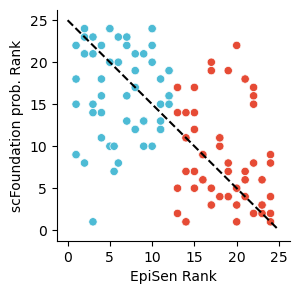

In [34]:
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.fold==spl].copy()
    tmp['EpiSen_score_rank']=ss.rankdata(tmp['EpiSen_score'].tolist())
    tmp['pred_rank']=ss.rankdata(tmp['pred'].tolist())
    sns.scatterplot(data=tmp,x = 'EpiSen_score_rank',y='pred_rank',hue=tmp['response'])
    plt.legend([],[], frameon=False)
sns.lineplot(x=[0, 25],y=[25, 0], linestyle = "--", color='black')
plt.xlabel('EpiSen Rank')
plt.xticks(np.arange(0,30,5))
plt.yticks(np.arange(0,30,5))
plt.ylabel('scFoundation prob. Rank');
plt.legend([],[], frameon=False)
# plt.savefig(f'{dname}_ranksp.pdf',bbox_inches='tight')

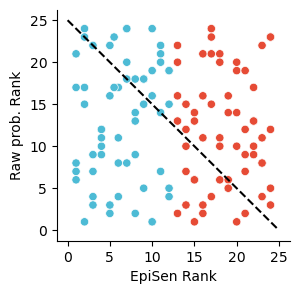

In [35]:
import scipy.stats as ss
for spl in ['split1','split2','split3','split4','split5']:
    tmp = tgtmeta[tgtmeta.rawfold==spl].copy()
    tmp['EpiSen_score_rank']=ss.rankdata(tmp['EpiSen_score'].tolist())
    tmp['rawpred_rank']=ss.rankdata(tmp['rawpred'].tolist())
    sns.scatterplot(data=tmp,x = 'EpiSen_score_rank',y='rawpred_rank',hue=tmp['response'])
sns.lineplot(x=[0, 25],y=[25, 0], linestyle = "--", color='black')
plt.xlabel('EpiSen Rank')
plt.ylabel('Raw prob. Rank');
plt.xticks(np.arange(0,30,5))
plt.yticks(np.arange(0,30,5))
plt.legend([],[], frameon=False)
# plt.savefig(f'{dname}_rawranksp.pdf',bbox_inches='tight')

In [36]:
speardf = pd.DataFrame(spr,columns=['spear'])
speardf['mode']='scFoundation'
rawspeardf = pd.DataFrame(rawspr,columns=['spear'])
rawspeardf['mode']='Baseline'
allspeardf = pd.concat([speardf,rawspeardf],axis=0)

<AxesSubplot:xlabel='mode', ylabel='spear'>

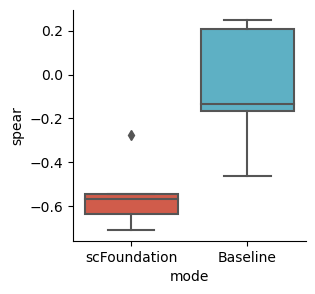

In [37]:
figsize(3,3)
sns.boxplot(data = allspeardf,x='mode',y='spear')

# Embedding

In [38]:
sil_sc={}
sil_bulk={}

In [39]:
def process(adata):
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)

## Embedding dataset1

In [40]:
dname = 'Sorafenib'
tgtemb = np.load(f'data/split_norm/Target_expr_resp_19264.{dname}_50M-0.1B-res_tgthighres4_embedding.npy')
srcemb = np.load(f'data/split_norm/Source_exprs_resp_19264.{dname}_50M-0.1B-res_embedding.npy')

In [41]:
sourcebulk = pd.read_csv(f'./data/split_norm/Source_exprs_resp_z.{dname}.tsv', sep='\t', index_col=0)
targetexp = pd.read_csv(f'./data/split_norm/Target_expr_resp_z.{dname}.tsv', sep='\t', index_col=0)

In [42]:
sourcebulk.index = 'bulk_'+sourcebulk.index.astype(str)

In [43]:
srcrawadata = sc.AnnData(sourcebulk.iloc[:,2:],dtype=np.float64)
tgtrawadata = sc.AnnData(targetexp.iloc[:,1:],dtype=np.float64)

process(srcrawadata)
process(tgtrawadata)
tgtrawadata.obs = pd.DataFrame(targetexp.iloc[:,0])
srcrawadata.obs = sourcebulk.iloc[:,:2]

tgtadata = sc.AnnData(pd.DataFrame(tgtemb,index=targetexp.index))
srcadata = sc.AnnData(pd.DataFrame(srcemb,index=sourcebulk.index))
process(srcadata)
process(tgtadata)
srcadata.obs = sourcebulk.iloc[:,:2]

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [44]:
Y_target = targetexp.iloc[:,0].tolist()
tgtmeta = pd.DataFrame(targetexp.iloc[:,0])
tgtadata.obs = tgtmeta
tgtrawadata.obs = tgtmeta
tgtadata

AnnData object with n_obs × n_vars = 120 × 3072
    obs: 'response'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [45]:
# NAME='SSC47'
NAME = 'Sorafenib'
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score
score_base = silhouette_score(tgtrawadata.obsm['X_pca'],tgtrawadata.obs['response'])
score_scFoundation = silhouette_score(tgtadata.obsm['X_pca'],tgtadata.obs['response'])
print(score_scFoundation,score_base)
sil_sc[NAME]=[score_scFoundation,score_base]

0.17014368 0.052581575


In [46]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score
score_base = silhouette_score(srcrawadata.obsm['X_pca'],srcrawadata.obs['response'])
score_scFoundation = silhouette_score(srcadata.obsm['X_pca'],srcadata.obs['response'])
print(score_scFoundation,score_base)
sil_bulk[NAME]=[score_scFoundation,score_base]

-0.006869799 -0.01387797


## Embedding dataset2

In [47]:
dname = 'Etoposide'
tgtemb = np.load(f'data/split_norm/Target_expr_resp_19264.{dname}_50M-0.1B-res_tgthighres4_embedding.npy')
srcemb = np.load(f'data/split_norm/Source_exprs_resp_19264.{dname}_50M-0.1B-res_embedding.npy')

In [48]:
sourcebulk = pd.read_csv(f'./data/split_norm/Source_exprs_resp_z.{dname}.tsv', sep='\t', index_col=0)
targetexp = pd.read_csv(f'./data/split_norm/Target_expr_resp_z.{dname}.tsv', sep='\t', index_col=0)

In [49]:
sourcebulk.index = 'bulk_'+sourcebulk.index.astype(str)

In [50]:
srcrawadata = sc.AnnData(sourcebulk.iloc[:,2:],dtype=np.float64)
tgtrawadata = sc.AnnData(targetexp.iloc[:,1:],dtype=np.float64)

process(srcrawadata)
process(tgtrawadata)
tgtrawadata.obs = pd.DataFrame(targetexp.iloc[:,0])
srcrawadata.obs = sourcebulk.iloc[:,:2]

tgtadata = sc.AnnData(pd.DataFrame(tgtemb,index=targetexp.index))
srcadata = sc.AnnData(pd.DataFrame(srcemb,index=sourcebulk.index))
process(srcadata)
process(tgtadata)
srcadata.obs = sourcebulk.iloc[:,:2]

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [51]:
Y_target = targetexp.iloc[:,0].tolist()

tgtmeta = pd.DataFrame(targetexp.iloc[:,0])

tgtadata.obs = tgtmeta
tgtrawadata.obs = tgtmeta

tgtadata

AnnData object with n_obs × n_vars = 1393 × 3072
    obs: 'response'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
# NAME='PC9'
NAME = 'Etoposide'
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score
score_base = silhouette_score(tgtrawadata.obsm['X_pca'],tgtrawadata.obs['response'])
score_scFoundation = silhouette_score(tgtadata.obsm['X_pca'],tgtadata.obs['response'])
print(score_scFoundation,score_base)
sil_sc[NAME]=[score_scFoundation,score_base]

0.093357 0.08527158


In [53]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score
score_base = silhouette_score(srcrawadata.obsm['X_pca'],srcrawadata.obs['response'])
score_scFoundation = silhouette_score(srcadata.obsm['X_pca'],srcadata.obs['response'])
print(score_scFoundation,score_base)
sil_bulk[NAME]=[score_scFoundation,score_base]

0.046692472 0.027508175


## Embedding dataset3

In [56]:
dname = 'PLX4720_451Lu'
tgtemb = np.load(f'data/split_norm/Target_expr_resp_19264.{dname}_50M-0.1B-res_tgthighres4_embedding.npy')
srcemb = np.load(f'data/split_norm/Source_exprs_resp_19264.{dname}_50M-0.1B-res_embedding.npy')

In [57]:
sourcebulk = pd.read_csv(f'./data/split_norm/Source_exprs_resp_z.{dname}.tsv', sep='\t', index_col=0)
targetexp = pd.read_csv(f'./data/split_norm/Target_expr_resp_z.{dname}.tsv', sep='\t', index_col=0)

In [58]:
sourcebulk.index = 'bulk_'+sourcebulk.index.astype(str)

In [59]:
srcrawadata = sc.AnnData(sourcebulk.iloc[:,2:],dtype=np.float64)
tgtrawadata = sc.AnnData(targetexp.iloc[:,1:],dtype=np.float64)

process(srcrawadata)
process(tgtrawadata)
tgtrawadata.obs = pd.DataFrame(targetexp.iloc[:,0])
srcrawadata.obs = sourcebulk.iloc[:,:2]

tgtadata = sc.AnnData(pd.DataFrame(tgtemb,index=targetexp.index))
srcadata = sc.AnnData(pd.DataFrame(srcemb,index=sourcebulk.index))
process(srcadata)
process(tgtadata)
srcadata.obs = sourcebulk.iloc[:,:2]

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [60]:
srcrawadata.obs = sourcebulk.iloc[:,:2]

In [61]:
Y_target = targetexp.iloc[:,0].tolist()
tgtmeta = pd.DataFrame(targetexp.iloc[:,0])
tgtadata.obs = tgtmeta
tgtrawadata.obs = tgtmeta
tgtadata

AnnData object with n_obs × n_vars = 155 × 3072
    obs: 'response'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [62]:
# NAME='451Lu'
NAME = 'PLX4720'
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score
score_base = silhouette_score(tgtrawadata.obsm['X_pca'],tgtrawadata.obs['response'])
score_scFoundation = silhouette_score(tgtadata.obsm['X_pca'],tgtadata.obs['response'])
print(score_scFoundation,score_base)
sil_sc[NAME]=[score_scFoundation,score_base]

0.066244826 0.087549075


In [63]:
from sklearn.metrics.cluster import silhouette_score
score_base = silhouette_score(srcrawadata.obsm['X_pca'],srcrawadata.obs['response'])
score_scFoundation = silhouette_score(srcadata.obsm['X_pca'],srcadata.obs['response'])
print(score_scFoundation,score_base)
sil_bulk[NAME]=[score_scFoundation,score_base]

0.031305946 0.026138503


In [64]:
silscdf = pd.DataFrame(sil_sc)
silscdf['mode']=['scFoundation','Baseline']
silscdf = silscdf.melt(id_vars='mode')

In [65]:
silbulkdf = pd.DataFrame(sil_bulk)
silbulkdf['mode']=['scFoundation','Baseline']
silbulkdf = silbulkdf.melt(id_vars='mode')

In [66]:
silscdf

,mode,variable,value
0,scFoundation,Sorafenib,0.170144
1,Baseline,Sorafenib,0.052582
2,scFoundation,Etoposide,0.093357
3,Baseline,Etoposide,0.085272
4,scFoundation,PLX4720,0.066245
5,Baseline,PLX4720,0.087549


In [67]:
silbulkdf

,mode,variable,value
0,scFoundation,Sorafenib,-0.006870
1,Baseline,Sorafenib,-0.013878
2,scFoundation,Etoposide,0.046692
3,Baseline,Etoposide,0.027508
4,scFoundation,PLX4720,0.031306
5,Baseline,PLX4720,0.026139


Text(0, 0.5, 'SIL score')

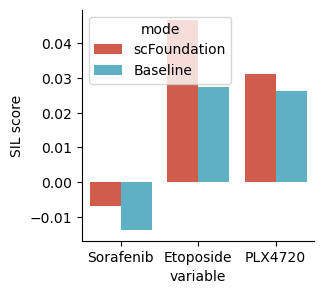

In [68]:
sns.barplot(data=silbulkdf,x='variable',y='value',hue='mode')
plt.ylabel('SIL score')
# plt.savefig('Bulk_silhouette_score.pdf',bbox_inches='tight')

Text(0, 0.5, 'SIL score')

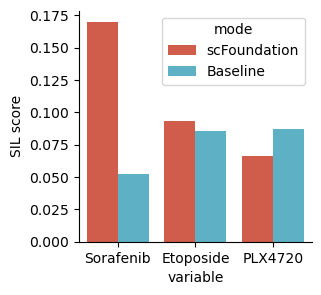

In [69]:
sns.barplot(data=silscdf,x='variable',y='value',hue='mode')
plt.ylabel('SIL score')
# plt.savefig('SC_silhouette_score.pdf',bbox_inches='tight')

Text(0, 0.5, 'SIL score')

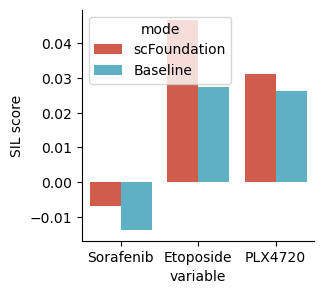

In [70]:
sns.barplot(data=silbulkdf,x='variable',y='value',hue='mode')
plt.ylabel('SIL score')
# plt.savefig('Bulk_silhouette_score.pdf',bbox_inches='tight')

Text(0, 0.5, 'SIL score')

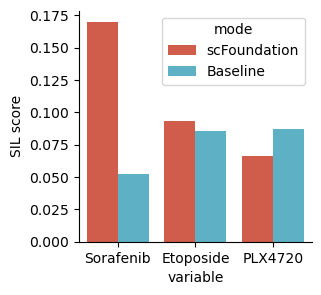

In [71]:
sns.barplot(data=silscdf,x='variable',y='value',hue='mode')
plt.ylabel('SIL score')
# plt.savefig('SC_silhouette_score.pdf',bbox_inches='tight')